This notebook follows Qiskit's sample on Shor's algorithm

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit import *
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [2]:
# U|y> = |ay (mod 15)>
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

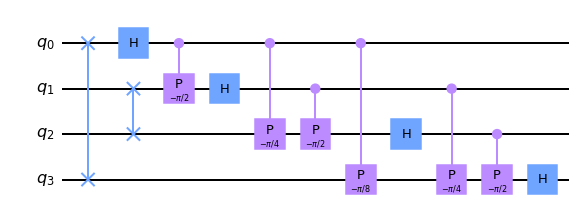

In [3]:
# For my own good, see qft_dagger circuit
qft_dagger(4).draw('mpl')

In [4]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7

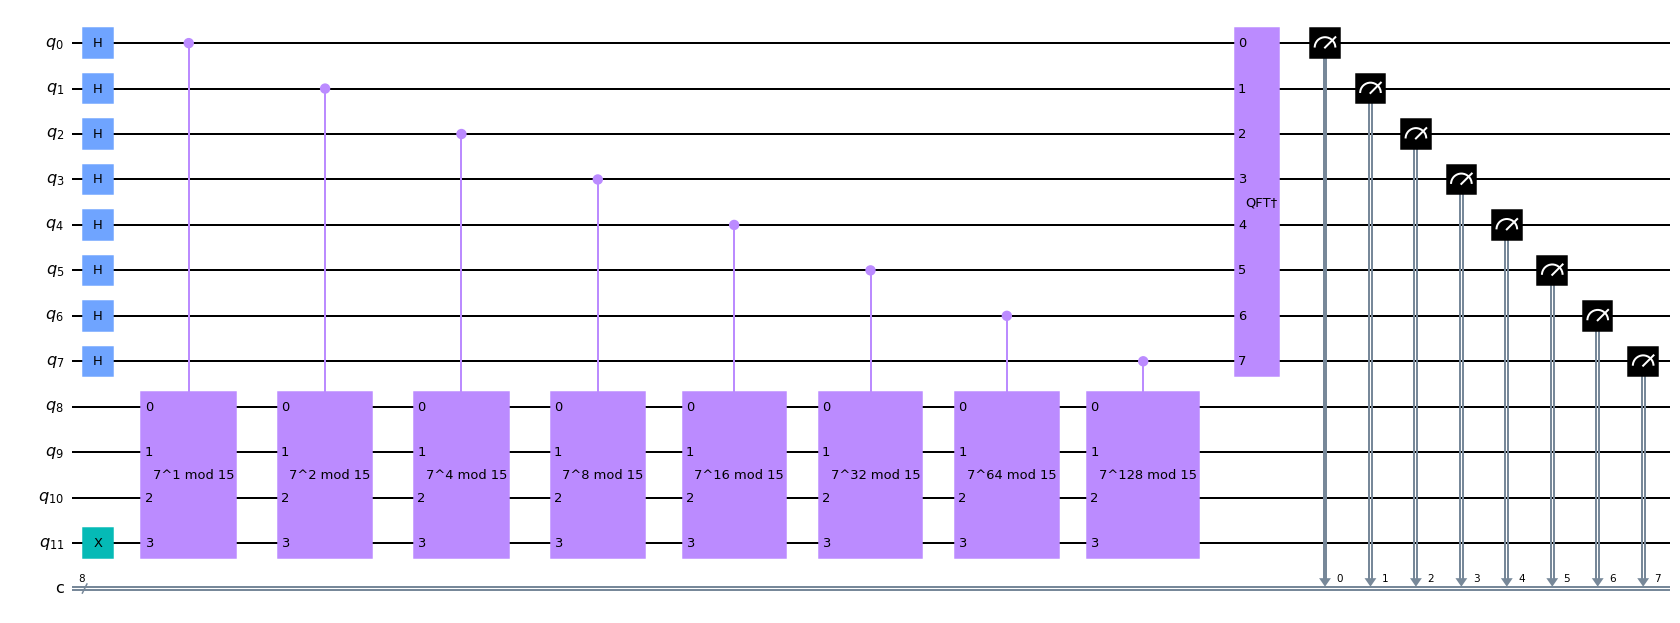

In [5]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw('mpl', fold=-1)  # -1 means 'do not fold'

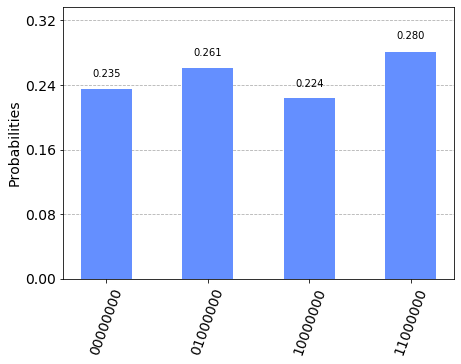

In [6]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [7]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


In [8]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.50      1/2            2
3   0.75      3/4            4


From my understanding, the fraction represents the phase $\phi = \frac{s}{r}$ and the values output by this algorithm can fail.  These fail when $s = 0$ or $s$ and $r$ are not coprime.  When this happens, we are given a factor of $r$.  Qiskit recommends that we just repeat the algorithm until we get our actual $r$.  

## Factoring 15

Questions:
1. Is the `n_count` supposed to be twice the number of qubits needed for N?
2. Does the flipping of one of the auxiliary registers  to state 1 happen always at the qubit with the largest index?
3. 

In [9]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialise counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    qasm_sim = Aer.get_backend('qasm_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, qasm_sim)
    obj = assemble(t_qc, shots=1)
    result = qasm_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [10]:
N = 15

np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)

7


In [11]:
from math import gcd # greatest common divisor
gcd(a, N)

1

In [12]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r

Register Reading: 01000000
Corresponding Phase: 0.250000


Fraction(1, 4)

In [13]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

4


In [14]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 5]


In [15]:
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 01000000
Corresponding Phase: 0.250000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


# My Implementation of Shor's for factoring 18

In [16]:
# TODO
def c_amod18(a, power):
    """Controlled multiplication by a mod 18"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

def qpe_amod18(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialise counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    qasm_sim = Aer.get_backend('qasm_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, qasm_sim)
    obj = assemble(t_qc, shots=1)
    result = qasm_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

### Helpful Diagrams for implementation:

#### Cayley Tables:

Multiplication in $\mathbb{Z}_{18}$ with the values coprime with $18$ and $1$:

$$
\begin{array}{c|cccccc}
\cdot & 1 & 5 & 7 & 11 & 13 & 17 \\ \hline
1 & 1 & 5 & 7 & 11 & 13 & 17 \\
5 & 5 & 7 & 17 & 1 & 11 & 13 \\
7 & 7 & 17 & 13 & 5 & 1 & 11 \\
11 & 11 & 1 & 5 & 13 & 17 & 7 \\
13 & 13 & 11 & 1 & 17 & 7 & 5 \\
17 & 17 & 13 & 11 & 7 & 5 & 1 
\end{array}
$$

#### Binary State Table:

$$
\begin{array}{c|cccccc}
 & 1 & 5 & 7 & 11 & 13 & 17 \\
 & 00001 & 00101 & 00111 & 01011 & 01101 & 10001 \\ \hline
5 & 5     & 7     & 17    & 1     & 11    & 13 \\
  & 00101 & 00111 & 10001 & 00001 & 01011 & 01101
\end{array}
$$

#### Karnaugh Maps:

Since I cannot figure out how to make nice looking Karnaugh Maps in latex, I have encoded the following image which shows what they should look like.  Note that $x$'s are don't care conditions meaning it can output either 0 or 1 and won't effect the circuit's correctness.

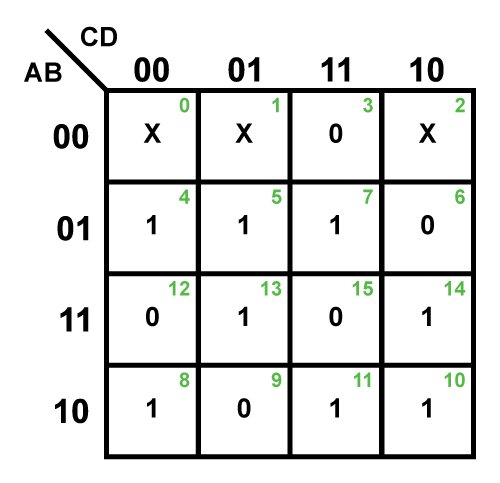

In [17]:
from IPython import display 
display.Image("https://www.allaboutcircuits.com/uploads/articles/KMap_Figure2.jpg")

##### Multiplication by 5:
For multiplication by 5, we have write our five bit string as $a_4a_3a_2a_1a_0$ and notice that $a_0$ is always $1$.  Thus, we just need to find values for $a_4, a_3, a_2, a_1$.  I do this through Karnaugh maps but in general I cannot continue to do this for more than 4 unknowns.

$a_1$:

$$
\begin{array}{|c|c|c|c|}
0 & x & 0 & 1 \\ \hline
x & 0 & x & 1 \\ \hline
x & x & x & x \\ \hline
0 & x & x & x
\end{array}
$$

Hence, $a_1 = a_2 \bar{a}_1$

$a_2$:

$$
\begin{array}{|c|c|c|c|}
1 & x & 0 & 1 \\ \hline
x & 0 & x & 0 \\ \hline
x & x & x & x \\ \hline
1 & x & x & x
\end{array}
$$

We have, $a_2 = \bar{a}_3 \bar{a}_1$

$a_3$:

$$
\begin{array}{|c|c|c|c|}
0 & x & 0 & 0 \\ \hline
x & 0 & x & 1 \\ \hline
x & x & x & x \\ \hline
1 & x & x & x
\end{array}
$$

Therefore, $a_3 = a_4 + a_3a_2$

$a_4$:

$$
\begin{array}{|c|c|c|c|}
0 & x & 1 & 0 \\ \hline
x & 0 & x & 0 \\ \hline
x & x & x & x \\ \hline
0 & x & x & x
\end{array}
$$

Thus, $a_4 = a_2 a_1$

In [19]:
def multByFive(a4, a3, a2, a1, a0):
    b1 = a2 and (not a1)
    b2 = (not a3) and (not a1)
    b3 = a4 or (a3 and a2)
    b4 = a2 and a1
    
    print("b0 = True")
    print("b1 = {}".format(b1))
    print("b2 = {}".format(b2))
    print("b3 = {}".format(b3))
    print("b4 = {}".format(b4))
    
    val = 0
    val += int(b4)
    val = val << 1
    val += int(b3)
    val = val << 1
    val += int(b2)
    val = val << 1
    val += int(b1)
    val = val << 1
    val += int(a0)
    
    return val

multByFive(False, False, False, False, True)

b0 = True
b1 = False
b2 = True
b3 = False
b4 = False


5

In [219]:
def statePrep(avals, measure=True):
    if measure:
        circ = QuantumCircuit(len(avals), len(avals))
    else:
        circ = QuantumCircuit(len(avals))
    
    for i in range(len(avals)):
        if avals[i]:
            circ.x(i)
    return circ

def buildA(a4, a3, a2, a1, a0):
    val = 0
    val += int(a4)
    val = val << 1
    val += int(a3)
    val = val << 1
    val += int(a2)
    val = val << 1
    val += int(a1)
    val = val << 1
    val += int(a0)
    
    return val

def mult5Mod18(a4, a3, a2, a1, a0):
    a = buildA(a4, a3, a2, a1, a0)
    
    print("Building Circuit for a = {}".format(a))
    
    circ = statePrep([a0, a1, a2, a3, a4], True)
    circ.barrier(range(5))
    
    circ.swap(1, 2)
    
    # Added for 17
    circ.swap(3, 4)
    
    circ.cx(2, 1)
    circ.x(2)
    
    # Added for 13 (Adjust to also work for 11)
    circ.cx(4, 3)
    circ.cx(4, 2)
    
    if a == 7 or a == 11 or a == 13:
        circ.x(4)
        
    circ.barrier(range(5))
    
    circ.measure(range(5), range(5))
    
    return circ

Building Circuit for a = 13


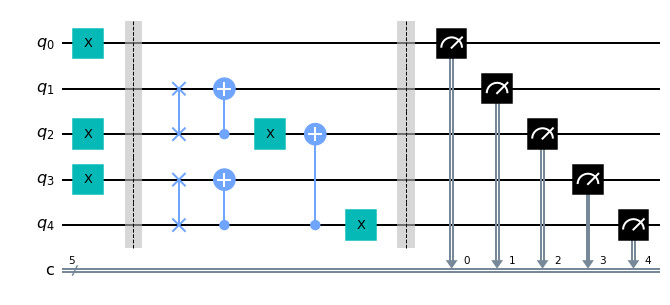

In [226]:
circ = mult5Mod18(False, True, True, False, True)
circ.draw('mpl')

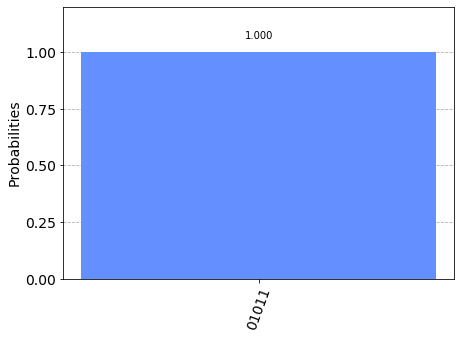

In [227]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=32)
res = job.result()
counts = res.get_counts()

plot_histogram(counts)

#### Binary State Table:

$$
\begin{array}{c|cccccc}
 & 1 & 5 & 7 & 11 & 13 & 17 \\
 & 00001 & 00101 & 00111 & 01011 & 01101 & 10001 \\ \hline
5 & 5     & 7     & 17    & 1     & 11    & 13 \\
  & 00101 & 00111 & 10001 & 00001 & 01011 & 01101
\end{array}
$$